# AI-Powered Stock Recommender System Using OpenAI API

In the ever-evolving financial markets, making informed investment decisions is crucial for both individual and institutional investors. This project aims to develop an AI-powered stock recommender system that leverages the advanced language models from OpenAI to analyze financial data, recent news, and visual insights. The system will provide personalized stock recommendations—whether to buy, sell, or hold—based on real-time data and sentiment analysis.

By integrating the OpenAI API with financial data sources, this project will harness the power of natural language processing (NLP) and machine learning to offer actionable insights. The recommender system will analyze a company's financial statements, market news, and visual data (such as stock price charts) to deliver concise, data-driven recommendations.

Key Features:
- Real-time Data Integration: The system will pull in the latest financial data and news, ensuring that recommendations are based on the most current information.
- NLP-Based Analysis: Using the OpenAI API, the system will analyze textual data, such as earnings reports and market news, to gauge sentiment and potential market impacts.
- Visual Data Interpretation: The model will include the capability to interpret stock price charts and other visual data, integrating these insights into the recommendation process.
- User Interaction: Investors can input specific stocks or market sectors of interest, and the system will provide tailored advice on whether to buy, sell, or hold.
- Scalability: The framework will be designed to accommodate a wide range of stocks and can be expanded to include other asset classes in the future.

Objective:
The primary objective of this project is to create a reliable, AI-driven stock recommender tool that simplifies the decision-making process for investors by providing them with comprehensive and actionable insights.

### Imports

In [1]:
import requests
import pandas as pd
from openai import OpenAI
from bs4 import BeautifulSoup
import json
import yfinance as yf
import ta
from datetime import datetime, date, timedelta
import matplotlib.pyplot as plt
from PIL import Image
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Fundamentel Data Analysis

### Fundamental Data Extraction from AlphaVantage

To reproduce this notebook, you will need an AlphaVantage API key and an OpenAI API key. The AlphaVantage API offers a free tier for basic access to financial data, while the OpenAI API requires a subscription for usage.

In [2]:
api_key = 'ODEFDRJB1TOOT9RQ'

Next we extract the fundamental data for the company from AlphaVantage, generate a summary, and create a string from the dataframe to put into ChatGPT.

In [3]:
# Data extraction
symbol = "AAPL"
end_date = datetime.today().date()
start_date = end_date - timedelta(days=1095)

In [4]:
start_date = datetime.combine(start_date, datetime.min.time())
end_date = datetime.combine(end_date, datetime.max.time())

In [7]:
# Define your Alpha Vantage API key and endpoint URLs
API_KEY = '' # Your AlphaVantage API key
BASE_URL = 'https://www.alphavantage.co/query'

In [8]:
# Define a function to retrieve data from Alpha Vantage
def get_alpha_vantage_data(function, symbol, api_key=API_KEY):
    params = {
        'function': function,
        'symbol': symbol,
        'apikey': api_key
    }
    response = requests.get(BASE_URL, params=params)
    data = response.json()
    return data

In [9]:
# Retrieve data
earnings_data = get_alpha_vantage_data('EARNINGS', symbol)
income_statement_data = get_alpha_vantage_data('INCOME_STATEMENT', symbol)
balance_sheet_data = get_alpha_vantage_data('BALANCE_SHEET', symbol)
cash_flow_data = get_alpha_vantage_data('CASH_FLOW', symbol)

In [10]:
# Extract and format data for DataFrame creation
def extract_data(data, key):
    if key in data:
        return pd.DataFrame(data[key])
    else:
        return pd.DataFrame()

In [11]:
# Convert data to DataFrames
df_earnings = extract_data(earnings_data, 'quarterlyEarningsReports')
df_income_statement = extract_data(income_statement_data, 'annualReports')
df_balance_sheet = extract_data(balance_sheet_data, 'annualReports')
df_cash_flow = extract_data(cash_flow_data, 'annualReports')

In [12]:
# Combine all DataFrames into one
combined_df = pd.concat([df_earnings, df_income_statement, df_balance_sheet, df_cash_flow], axis=1)

In [13]:
combined_df.tail()

,fiscalDateEnding,reportedCurrency,grossProfit,totalRevenue,costOfRevenue,costofGoodsAndServicesSold,operatingIncome,sellingGeneralAndAdministrative,researchAndDevelopment,operatingExpenses,...,dividendPayoutCommonStock,dividendPayoutPreferredStock,proceedsFromIssuanceOfCommonStock,proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet,proceedsFromIssuanceOfPreferredStock,proceedsFromRepurchaseOfEquity,proceedsFromSaleOfTreasuryStock,changeInCashAndCashEquivalents,changeInExchangeRate,netIncome
11,2012-09-30,USD,68662000000,156508000000,100486000000,87846000000,55241000000,10040000000,3381000000,13421000000,...,2488000000,None,665000000,0,None,665000000,None,931000000,None,41733000000
12,2011-09-30,USD,43818000000,108249000000,73630000000,64431000000,33790000000,7599000000,2429000000,10028000000,...,None,None,831000000,0,None,831000000,None,-1446000000,None,25922000000
13,2010-09-30,USD,25684000000,65225000000,45873000000,39541000000,18385000000,5517000000,1782000000,7299000000,...,None,None,912000000,None,None,912000000,None,5998000000,None,14013000000
14,2009-09-30,USD,17222000000,42905000000,29832000000,25683000000,11740000000,4149000000,1333000000,5482000000,...,None,None,475000000,None,None,475000000,None,-6612000000,None,8235000000
15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The dataframe has mising values due to different reporting dates.  NaNs and NaTs can be left in the DataFrame when passing it to ChatGPT for analysis. The model can understand and work with missing values (NaN and NaT) when interpreting data.

In [14]:
csv_string = combined_df.to_string(index=False)

### AI Model Analysis of Fundamental Data

In [15]:
client = OpenAI()

We will provide the AI model a system prompt to ensure the it understands its role in analyzing financial data, making recommendations, and summarizing insights.

In [16]:
system_prompt = """ You are a financial analyst specializing in stock data analysis. Your role is to analyze financial data, including quarterly \n
earnings reports, revenue trends, net income, and earnings per share, and provide actionable insights based on this data. When given stock data, \n
you should:
\n
1. **Analyze**: Identify key trends and changes in the financial metrics over time.
2. **Compare**: Provide comparisons between different stocks or between different time periods.
3. **Recommend**: Offer investment recommendations such as buy, sell, or hold based on the analysis.
4. **Summarize**: Create clear, concise summaries of the financial performance and any significant findings.
5. **Consider Context**: Take into account recent news or other relevant factors that may impact stock performance.
\n
Always ensure that your responses are grounded in the data provided and present your analysis in a structured and understandable manner."""

Next we provide a user prompt and the data to the AI model.

In [17]:
user_prompt = f"""I have provided the financial data for {symbol} below:
\n\n{csv_string}\n\n
Please analyze this data and provide a comprehensive analysis."""

In [18]:
response = client.chat.completions.create(
    model='gpt-4o-mini',
    messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt},
    ],
    temperature=0,
    # max_tokens=200,
)

In [19]:
generated_text = response.choices[0].message.content
print(generated_text)

### Comprehensive Analysis of AAPL Financial Data

#### 1. **Key Financial Metrics Overview**
- **Gross Profit**: AAPL's gross profit has shown a slight decline from $170.78 billion in 2022 to $169.15 billion in 2023, indicating a decrease in profitability despite a relatively stable revenue base.
- **Total Revenue**: Total revenue decreased from $391.40 billion in 2022 to $379.35 billion in 2023, reflecting a downward trend in sales.
- **Net Income**: Net income also decreased from $99.80 billion in 2022 to $94.68 billion in 2023, suggesting that AAPL is facing challenges in maintaining profitability.
- **Earnings Per Share (EPS)**: While EPS data is not provided directly, the decline in net income suggests a potential decrease in EPS, which could impact investor sentiment.

#### 2. **Trends Over Time**
- **Revenue Trends**: AAPL's total revenue peaked in 2022 but has since declined. This could be attributed to various factors, including market saturation, increased competition, or ch

The AI model provide us with an analysis of the trends being positive and a "Buy" recommendation.

## News Sentiment Analysis

### News Data Extraction from Finviz.com

Next we scrape news data from Finviz.com using BeautifulSoup.  To enhance our AI model's learning by incorporating the interactions between fundamental data, technical data, and news sentiment, we would ideally use three years of historical news data alongside the existing datasets. However, the high cost of acquiring such extensive historical news data and the token limitations for processing large datasets make this approach impractical. Instead, a more feasible solution would be to fine-tune the model using a curated set of historical news data. This approach would allow us to leverage the news data effectively while managing costs and token constraints.

In [20]:
def scrape_finviz_news(symbol):
    url = f"https://finviz.com/quote.ashx?t={symbol}"
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
    
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, 'html.parser')

    news_table = soup.find('table', class_='fullview-news-outer')
    news = []

    for row in news_table.findAll('tr'):
        try:
            date_time = row.td.text.strip()
            title = row.a.text.strip()
            link = row.a['href'].strip()

            # Extract and summarize full article text
            article_text = get_article_text(link)
            summary = summarize_text(article_text)
            
            news.append({'Date/Time': date_time, 'Title': title, 'Link': link, 'Summary': summary})
        except AttributeError:
            continue
    
    # Save to JSON file
    with open(f'{symbol}_news.json', 'w') as file:
        json.dump(news, file, indent=4)
    
    return news

def get_article_text(url):
    try:
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'html.parser')

        # Assuming the article text is in <p> tags or similar
        paragraphs = soup.find_all('p')
        article_text = ' '.join([p.get_text() for p in paragraphs])
        
        return article_text
    except Exception as e:
        print(f"Error retrieving article from {url}: {e}")
        return "Error retrieving article text."

def summarize_text(text):
    user_prompt = f"""Please summarize the following article:

    ```
    {text}
    ```
    """
    try:
        response = client.chat.completions.create(
            model="gpt-4o-mini",  # or use "gpt-4" or another available model
            messages=[
                {"role": "user", "content": user_prompt},
                ],
            max_tokens=200,  # Adjust the number of tokens as needed
            temperature=0.5
        )
        summary = response.choices[0].message.content
        return summary
    except Exception as e:
        print(f"Error summarizing text: {e}")
        return "Error summarizing text."

The news articles needed to be summarized because the max number of tokens was being exceeded when trying to put all the articles into the AI model at the same time.

In [21]:
news_items = scrape_finviz_news(symbol)
for item in news_items:
    print(f"Date/Time: {item.get('Date/Time', 'N/A')}")
    print(f"Title: {item.get('Title', 'N/A')}")
    print(f"Link: {item.get('Link', 'N/A')}")
    print(f"Summary: {item.get('Summary', 'N/A')[:500]}...")  # Print first 500 characters of summary
    print()

Date/Time: Today 08:10AM
Title: What one AI CEO learned by working 20 feet from Apple's Steve Jobs
Link: https://finance.yahoo.com/news/what-one-ai-ceo-learned-by-working-20-feet-from-apples-steve-jobs-121028395.html
Summary: Chet Kapoor, the chairman and CEO of AI company DataStax, shares valuable business lessons learned from his time working with Steve Jobs at NeXT from 1989 to 1993. Kapoor emphasizes that true innovation requires pushing people beyond their perceived limits, a trait he admired in Jobs. He highlights Jobs's focus on understanding consumer needs rather than wants, which he believes is crucial for impactful product development. Kapoor also notes the importance of having a clear purpose in technology...

Date/Time: 05:04AM
Title: 4 Reasons to Follow Warren Buffett and Sell Apple Stock
Link: https://finance.yahoo.com/m/326b7299-f176-31a3-a2a3-47d996ac5e48/4-reasons-to-follow-warren.html
Summary: The article expresses gratitude for patience and informs that engineers are

In [22]:
# Load the JSON file
with open('AAPL_news.json', 'r') as file:
    news_data = json.load(file)

In [23]:
# Prepare data for OpenAI
def prepare_for_openai(news_data):
    texts = [item['Summary'] for item in news_data]
    return texts

In [24]:
prepared_data = prepare_for_openai(news_data)

In [25]:
prepared_data

["Chet Kapoor, the chairman and CEO of AI company DataStax, shares valuable business lessons learned from his time working with Steve Jobs at NeXT from 1989 to 1993. Kapoor emphasizes that true innovation requires pushing people beyond their perceived limits, a trait he admired in Jobs. He highlights Jobs's focus on understanding consumer needs rather than wants, which he believes is crucial for impactful product development. Kapoor also notes the importance of having a clear purpose in technology creation, warning against developing solutions without a defined problem. He reflects on Jobs's dedication to making a significant societal impact and aims to build products that developers love and that transform enterprises. DataStax has successfully raised $305 million to support its growth, with a valuation of $1.6 billion. The article underscores Kapoor's ongoing inspiration from Jobs's relentless pursuit of innovation and user-centered design.",
 'The article expresses gratitude for pat

### AI Model Analysis of News Data

We provide the AI model with a new system prompt and user prompt so it understands its role as analyzing news sentiment.

In [26]:
system_prompt = f""" You are provided with a collection of recent news articles concerning {symbol}. Your task is to analyze these articles and \n
provide insights based on the following aspects:
\n
Key Trends and Sentiments:
\n
Identify the major themes and trends in the news coverage.
Determine the overall sentiment (positive, negative, neutral) of the news concerning the stock.
\n
Impact Assessment:
\n
Assess how the news might impact the stock’s performance. Consider factors such as potential market reactions, changes in investor sentiment, and \n
any implications for the company's future.
\n
Comparative Analysis:
\n
Compare the current news with historical news trends for the stock, if applicable. Highlight any significant changes or patterns.
\n
Relevance to Investment Decisions:
\n
Based on the news analysis, provide insights or recommendations regarding investment decisions for {symbol}. Consider whether the news \n
suggests a potential buying, selling, or holding strategy.
\n
Summary of Findings:
\n
Summarize the key takeaways from the news analysis. Provide a concise overview of the main points that investors should be aware of."""


In [27]:
user_prompt = f""" This is recent news summaries for {symbol}:
\n\n {prepared_data} \n\n
Please analyze the news and provide insights."""

In [28]:
response = client.chat.completions.create(
    model='gpt-4o-mini',
    messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt},
    ],
    temperature=0,
    # max_tokens=200,
)

In [29]:
generated_text = response.choices[0].message.content
print(generated_text)

### Key Trends and Sentiments:

1. **Major Themes:**
   - **AI Integration and Competition:** A significant focus on Apple's upcoming iPhone 16 and its potential AI features, as well as competition from Google’s Pixel 9 lineup, which emphasizes AI capabilities.
   - **Investor Sentiment:** Mixed reactions from prominent investors, with some reducing stakes in Apple while others are increasing their investments, indicating a cautious but optimistic outlook on the stock.
   - **Regulatory Scrutiny:** Ongoing investigations into Apple’s market practices, particularly in India, and the implications of antitrust actions against Google, which could indirectly affect Apple.

2. **Overall Sentiment:**
   - The sentiment surrounding AAPL appears to be **neutral to slightly positive**. While there are concerns regarding valuation and regulatory scrutiny, analysts remain optimistic about Apple's growth potential, especially with the anticipated iPhone 16 launch and strong earnings projections.

#

## Technical Data Analysis

### Stock Data Extraction from Yahoo Finance

Next we use yfinance to extract the Open, High, Low, and Volume data.  Then we create the RSI data

In [30]:
df = yf.download(symbol, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [31]:
df['RSI'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()

In [32]:
macd_indicator = ta.trend.MACD(df['Close'])
df['MACD'] = macd_indicator.macd()  # MACD line
df['MACD_signal'] = macd_indicator.macd_signal()  # Signal line
df['MACD_diff'] = macd_indicator.macd_diff() 

In [33]:
df.dropna(inplace=True)
df.head()# Plotting function
def plot_stock_data(df, filename='stock_plot.png'):
    fig, ax = plt.subplots(4, 1, figsize=(14, 14), sharex=True)
    
    # Candlestick chart
    for i in range(len(df)):
        color = 'green' if df['Close'][i] >= df['Open'][i] else 'red'
        ax[0].plot([df.index[i], df.index[i]], [df['Low'][i], df['High'][i]], color=color, lw=0.5)
        ax[0].add_patch(plt.Rectangle((df.index[i] - pd.Timedelta(minutes=10), df['Open'][i]),
                                      pd.Timedelta(minutes=20), df['Close'][i] - df['Open'][i],
                                      color=color, alpha=0.8))
    ax[0].set_title('Candlestick Chart')
    ax[0].set_ylabel('Price')

    # Volume chart
    ax[1].bar(df.index, df['Volume'], color='blue', label='Volume')
    ax[1].set_title('Volume Chart')
    ax[1].set_ylabel('Volume')

    # RSI chart
    ax[2].plot(df.index, df['RSI'], color='orange', label='RSI')
    ax[2].axhline(70, color='red', linestyle='--', label='Overbought (70)')
    ax[2].axhline(30, color='green', linestyle='--', label='Oversold (30)')
    ax[2].set_title('RSI Chart')
    ax[2].set_ylabel('RSI')

    # MACD chart
    ax[3].plot(df.index, df['MACD'], color='blue', label='MACD Line')
    ax[3].plot(df.index, df['MACD_signal'], color='red', label='Signal Line')
    ax[3].bar(df.index, df['MACD_diff'], color='gray', alpha=0.5, label='MACD Histogram')
    ax[3].set_title('MACD Chart')
    ax[3].set_ylabel('MACD')
    ax[3].legend()

    plt.tight_layout()
    
    # Save the plot as an image file
    plt.savefig(filename)
    print(f"Plot saved as {filename}")

    plt.show()

In [34]:
# Plotting function
def plot_stock_data(df, filename='stock_plot.png'):
    fig, ax = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
    
    # Candlestick chart
    for i in range(len(df)):
        color = 'green' if df['Close'][i] >= df['Open'][i] else 'red'
        ax[0].plot([df.index[i], df.index[i]], [df['Low'][i], df['High'][i]], color=color, lw=0.5)
        ax[0].add_patch(plt.Rectangle((df.index[i] - pd.Timedelta(minutes=10), df['Open'][i]),
                                      pd.Timedelta(minutes=20), df['Close'][i] - df['Open'][i],
                                      color=color, alpha=0.8))
    ax[0].set_title('Candlestick Chart')
    ax[0].set_ylabel('Price')

    # Volume chart
    ax[1].bar(df.index, df['Volume'], color='blue', label='Volume')
    ax[1].set_title('Volume Chart')
    ax[1].set_ylabel('Volume')

    # RSI chart
    ax[2].plot(df.index, df['RSI'], color='orange', label='RSI')
    ax[2].axhline(70, color='red', linestyle='--', label='Overbought (70)')
    ax[2].axhline(30, color='green', linestyle='--', label='Oversold (30)')
    ax[2].set_title('RSI Chart')
    ax[2].set_ylabel('RSI')

    plt.tight_layout()
    
    # Save the plot as an image file
    plt.savefig(filename)
    print(f"Plot saved as {filename}")

    plt.show()

Plot saved as stock_plot.png


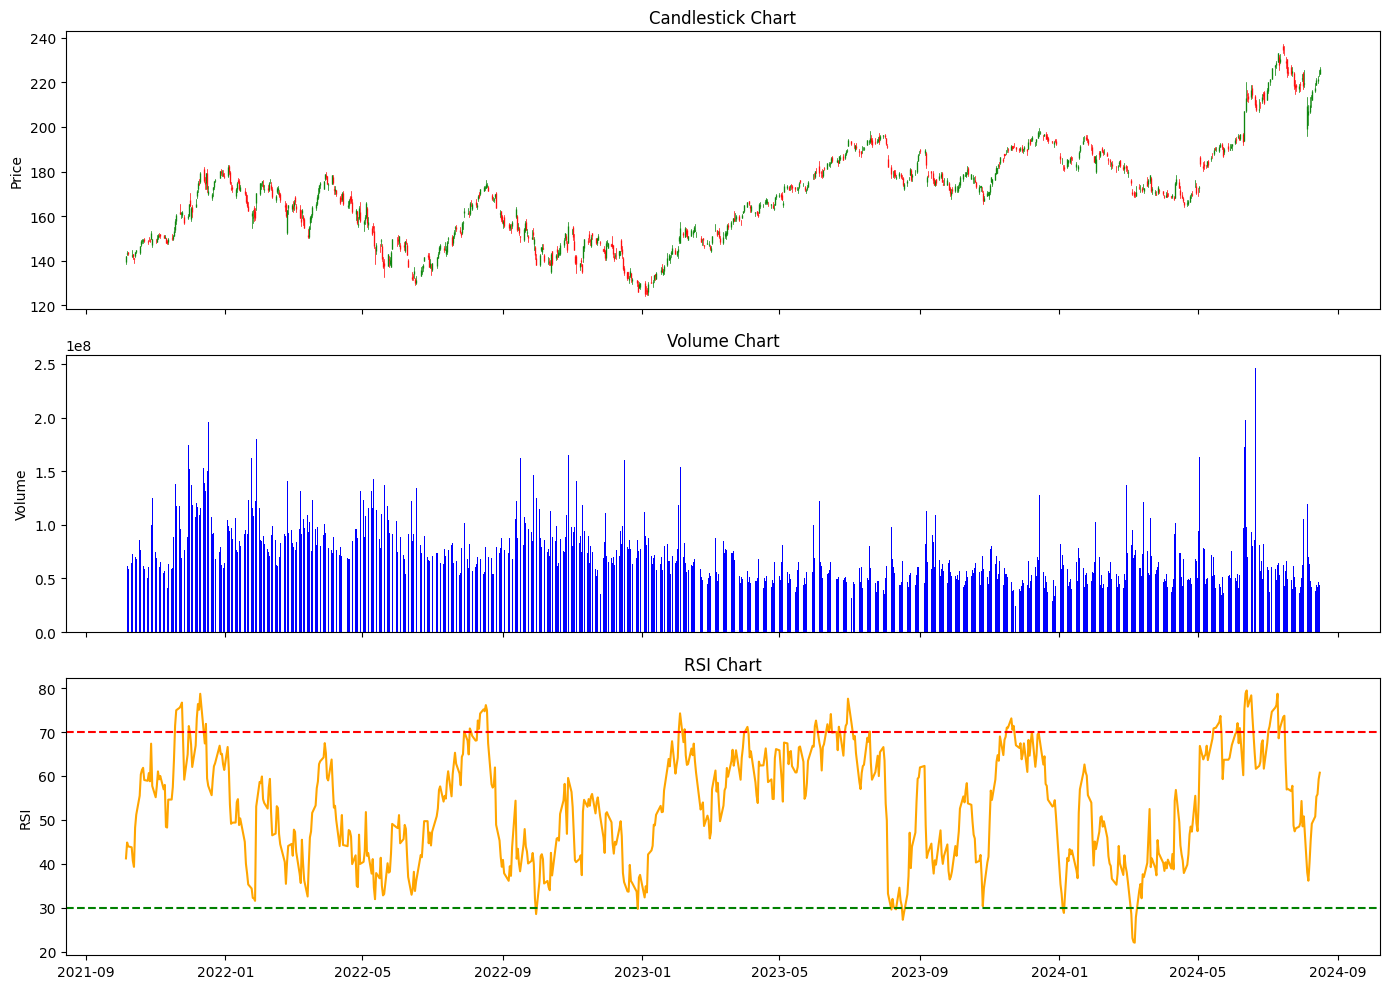

In [35]:
plot_stock_data(df)

In [36]:
def image_complete(prompt, img_url):
    response = client.chat.completions.create(
        model='gpt-4o-mini',
        messages=[
            {
                "role": "user",
                "content": [
                    {"type": "text", "text":prompt},
                    {
                        "type": "image_url",
                        "image_url": {"url": img_url},
                    }
                ]
            }
        ]
    )
    print(response.choices[0].message.content)

We’ve been utilizing GPT-3.5-turbo for its cost-effectiveness. However, for image analysis, we will need to switch to GPT-4-turbo.

In [37]:
system_prompt = f""" You are given an image depicting the price action of {symbol}. The image includes:

Candlestick Chart: This chart shows the stock's opening, closing, high, and low prices over time. Each candlestick represents a specific time period \n
and visualizes the stock's price movement within that period.
\n
Volume Data: Below the candlestick chart, there is a volume chart indicating the number of shares traded over the same time periods.
\n
Technical Indicators: The image includes various technical indicators, such as:
\n
Relative Strength Index (RSI): A momentum oscillator that measures the speed and change of price movements.
\n
MACD (Moving Average Convergence Divergence): A trend-following momentum indicator that shows the relationship between two moving averages of a \n
stock's price.
\n
Instructions:
\n
Analyze Price Action:
\n
Examine the candlestick chart to identify significant price movements, trends, and patterns.
\n
Note any bullish or bearish trends, reversal patterns, or other significant candlestick formations.
\n
Interpret Volume Data:
\n
Assess how the volume correlates with the price action. Identify any volume spikes or drops and their potential impact on price trends.
\n
Evaluate Technical Indicators:
\n
RSI: Determine if the stock is overbought (RSI > 70) or oversold (RSI < 30). Look for RSI trends and crossovers.
\n
MACD: Analyze the MACD line, Signal line, and MACD histogram. Identify any crossovers or divergences and their implications for stock momentum.
\n
Provide Insights:
\n
Summarize the overall market sentiment based on the candlestick patterns, volume data, and technical indicators.
\n
Offer potential investment insights or recommendations based on the analysis.
\n
Contextualize Findings:
\n
If applicable, relate your findings to broader market trends or recent news that may influence the stock's performance.
\n
Goal:
\n
Deliver a clear and comprehensive analysis of the stock's price action using the provided image. Your insights should help understand current market \n
conditions and potential future movements.
"""

In [38]:
prompt = "Please provide an analysis of the stock's trends, volume, and technical indicators, summarize your insights, and make recommendations."
img_url = "https://github.com/AndrewFSee/Profile_Projects/blob/main/images/stock_plot.png?raw=true"

In [39]:
image_complete(prompt, img_url)

### Stock Analysis

#### 1. **Candlestick Chart**
- **Trend:** The stock shows a general upward trend with several fluctuations. There are periods of consolidation followed by breakout movements.
- **Recent Movement:** A notable upward spike is observed at the end of the chart, suggesting bullish sentiment.

#### 2. **Volume Chart**
- **Trends in Volume:** The volume chart displays spikes at different points, especially coinciding with upward price movements. High volume during price increases indicates strong interest and confirms the moves.
- **Recent Activity:** Recent trading volumes appear to increase significantly, which could indicate heightened market interest or accumulation by buyers.

#### 3. **RSI (Relative Strength Index)**
- **Current Level:** The RSI oscillates between 30 and 70, with recent values hovering around the upper 60s to 70, indicating near overbought conditions.
- **Interpretation:** An RSI above 70 suggests that the stock may be overbought, while values aroun

## AI Stock Recommender

So far, we’ve developed individual AI models to analyze fundamental data, news sentiment, and technical indicators. Our next step is to integrate these models into a unified AI-driven stock recommender system.

In [40]:
def complete(messages):
    # takes in all messages instead of just single prompt
    completion = client.chat.completions.create(
        model='gpt-4o-mini',
        messages=messages,
        temperature=0,
        # max_tokens=200,
    )
    return completion

To address the issue of the AI model forgetting information between prompts, we’ll implement a class to manage and retain context from previous interactions.

In [41]:
class Assistant:
    def __init__(self):
        self.messages = [
            {"role": "system", "content": system_prompt}
        ]

    def query(self, prompt, img_url=None):
        # Create the message content
        message_content = [{"type": "text", "text": prompt}]
        
        # If an image URL is provided, add it to the message
        if img_url:
            message_content.append({
                "type": "image_url",
                "image_url": {"url": img_url},
            })
        
        # Add the message to history
        self.messages.append({
            "role": "user", "content": message_content,
        })

        # Get completion
        completion = complete(self.messages)

        # Get response string
        content = completion.choices[0].message.content

        # Add response to history
        self.messages.append({
            "role": "assistant", "content": content,
        })

        # Show the response
        print(content)

In [42]:
system_prompt = f"""You are an AI stock recommender bot with access to various types of data for {symbol}. Your goal is to analyze and provide stock \n
recommendations based on:
\n
Fundamental Data: This includes key financial metrics such as earnings, revenue, net income, and other financial ratios.
\n
Recent News Summaries: Summaries of recent news articles related to the stock, highlighting key events, sentiment, and market impact.
\n
Technical Data: Technical indicators and chart patterns, including moving averages, RSI, MACD, and candlestick patterns.
\n
Instructions:
\n
Analyze Fundamental Data:
\n
Review the provided financial metrics to assess the company's financial health and performance.
\n
Identify any significant trends, strengths, or weaknesses.
\n
Interpret Recent News:
\n
Evaluate the sentiment and relevance of the recent news summaries.
\n
Consider how the news may impact the stock’s performance or market perception.
\n
Assess Technical Data:
\n
Analyze the technical indicators and chart patterns to determine market trends and momentum.
\n
Identify any signals or patterns that suggest potential price movements.
\n
Provide Recommendations:
\n
Based on the comprehensive analysis of fundamental data, recent news, and technical indicators, offer stock recommendations.
\n
Always indicate whether to buy, sell, or hold the stock, and provide a rationale for your recommendation.
\n
Contextualize Findings:
\n
Relate your recommendations to current market conditions or any broader economic factors that might influence the stock.
\n
Goal:
\n
Deliver a well-rounded recommendation that integrates insights from all available data sources to guide investment decisions."""

We create a new system prompt for the comprehensive stock recommender.  Since the AI model sometimes doesn't offer a recommendation to buy, sell, or hold, the prompt tells it to always provide the recommendation

In [54]:
bot = Assistant()

In [55]:
bot.query(f""" Here is the financial data for {symbol}:
\n\n{csv_string}\n\n
Please analyze the data and provide insights.""")

### Fundamental Data Analysis

#### Key Financial Metrics (as of September 30, 2023):
- **Gross Profit**: $169.15 billion
- **Total Revenue**: $379.35 billion
- **Net Income**: $99.80 billion
- **Operating Income**: $114.30 billion
- **Total Assets**: $352.58 billion
- **Total Liabilities**: $264.97 billion
- **Total Shareholder Equity**: $87.61 billion

#### Trends and Insights:
1. **Revenue Growth**: AAPL's total revenue has shown a slight decline from $391.40 billion in 2022 to $379.35 billion in 2023. This indicates a potential slowdown in sales growth, which could be a concern for investors.
  
2. **Profitability**: The net income margin remains strong at approximately 26.3% ($99.80 billion net income on $379.35 billion revenue), indicating effective cost management and strong pricing power.

3. **Asset Management**: The total assets have remained relatively stable, but the total liabilities have increased, leading to a decrease in shareholder equity. This could indicate increased

In [56]:
bot.query(f""" This is recent news summaries for {symbol}:
\n\n {prepared_data} \n\n
Please analyze the news and provide insights.""")

### Recent News Analysis for AAPL

#### Key Themes and Insights:

1. **Product Innovations and Market Competition**:
   - **AI Integration**: Analysts predict that the upcoming iPhone 16 will feature AI-driven enhancements, which could lead to a significant growth phase for Apple. This aligns with the broader trend of integrating AI into consumer technology, as seen with Google's recent Pixel 9 launch, which emphasizes AI capabilities. The competition is heating up, and Apple's ability to innovate in this space will be crucial for maintaining its market position.
   - **Foldable Devices**: Rumors about Apple developing a foldable iPhone suggest that the company is exploring new product categories, which could attract consumer interest and drive sales in the future.

2. **Financial Performance and Analyst Sentiment**:
   - **Earnings Projections**: Analysts expect Apple to report strong earnings, with projections indicating an 8.9% year-over-year increase for the current quarter. This p

In [57]:
bot.query(f""" This is an image of price action, volume, MACD, and RSI for the last 3 years for {symbol}:
Please analyze the image and provide insights""", img_url=img_url)

### Technical Analysis of AAPL Price Action, Volume, MACD, and RSI

#### 1. **Candlestick Chart**
- **Price Trend**: The price action shows a general upward trend over the last three years, with notable fluctuations. The price has recently approached the $200 mark, indicating strong resistance.
- **Volatility**: There are periods of consolidation followed by sharp movements, suggesting that the stock has experienced both bullish and bearish phases.

#### 2. **Volume Chart**
- **Volume Spikes**: The volume chart indicates several spikes in trading volume, particularly during significant price movements. High volume often accompanies price increases, suggesting strong buying interest.
- **Recent Activity**: The recent increase in volume correlates with the upward price movement, indicating that the current rally may have strong support from investors.

#### 3. **RSI Chart**
- **Current RSI Level**: The RSI is currently hovering around the 70 mark, which indicates that AAPL is approaching

In [58]:
bot.query(f"""Given the financial data, recent news, and image for {symbol}, would you recommend this stock as a buy, sell or hold?""", 
          img_url=img_url)

### Recommendation for AAPL: **Hold**

#### Rationale:

1. **Financial Performance**:
   - AAPL has shown strong financial metrics, including robust revenue and net income growth. However, recent news indicates some concerns about stock valuation and potential market saturation.

2. **Recent News Sentiment**:
   - Positive analyst sentiment regarding upcoming product launches (iPhone 16) and AI integration suggests potential for growth. However, the reduction of stakes by major investors like Berkshire Hathaway raises caution.

3. **Technical Analysis**:
   - **Candlestick Chart**: The price is approaching significant resistance around $200, which may limit further upward movement in the short term.
   - **Volume**: Recent spikes in volume support the current price action, indicating strong investor interest.
   - **RSI**: The RSI is nearing overbought territory (around 70), suggesting a potential pullback or consolidation could occur soon.
   - **MACD**: The MACD shows bullish momentu

So given all the data the bot recommends a Hold for the stock.

In [52]:
# Reinitialize the bot
bot = Assistant()

Next let's try putting everything in at the same time to see if that works and still gives the same recommendation.

In [53]:
bot.query(f"""Here is the financial data for {symbol}:
\n\n{csv_string}\n\n
This is recent news summaries for {symbol}:
\n\n {prepared_data} \n\n
This is an image of price action, volume, MACD, and RSI for the last 3 years for {symbol}
\n
Given the financial data, recent news, and image for {symbol}, would you recommend this stock as a buy, sell or hold?
""", img_url=img_url)

### Recommendation for AAPL Stock

**Recommendation: Buy**

#### Fundamental Analysis
1. **Financial Performance**:
   - **Revenue Growth**: AAPL reported record revenues of $379.35 billion for the fiscal year ending September 2023, showing resilience despite market challenges.
   - **Profitability**: The net income from continuing operations was $99.8 billion, indicating strong profitability.
   - **Strong Cash Position**: AAPL ended the quarter with $153 billion in cash and marketable securities, providing ample liquidity for investments and shareholder returns.

2. **Growth Potential**:
   - Analysts predict significant growth driven by the upcoming iPhone 16 launch, with expectations of over 240 million units sold in FY25, particularly in China.

#### Recent News Sentiment
1. **Positive Analyst Outlook**: Analysts from Wedbush have a bullish outlook on AAPL, anticipating a strong upgrade cycle for iPhones.
2. **Market Position**: Despite some concerns regarding Berkshire Hathaway r

The AI model now recommends a Buy rating for the stock. It's observed that the model's responses can vary slightly depending on whether it's provided with all the relevant data at once or if the data is drawn from its memory. Further research is needed to determine which approach yields more accurate and reliable results.